This blog post uses linear algebra to create a spectral clustering algorithm. Clustering is separating data points into two blobs. This is relatively simple for circular blobs, but when the data is shaped differently we need a more complex algorithm, which is where spectral clustering comes in.

## Walking through an example

### Imports

We will use the following packages in this project.

In [31]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
import sklearn.metrics
from scipy.optimize import minimize 

### Data

This is the dataset we will working on in this exploritory phase of the project.

In [32]:
np.random.seed(1234)
n = 200

#Make moons creates cresent moon shaped blobs
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)

### Constructing the similarity matrix A

This is an n by n matrix where each entry `A[i,j]` equals `1` if `X[i]` is within a set parameter `epsilon` of `X[j]` and equals `0` if not. Additionally, the diagonally entries are zero.

In [33]:
#Set the parameter
epsilon = 0.4

#Computes whether each pair is within epsilon
A = sklearn.metrics.pairwise_distances(X) < epsilon

#The diagonals will all be one as they are the same, so we subtract 1
#This will also turn the boolean values to ints of 1 and 0 
A = A - np.diag(np.ones(n))

### Computing the binary norm cut

Next we will work toward creating a norm_cut function. A low norm cut will tell us the clusters $C_0$ and $C_1$ are a good partition of the data. The formula for the binary norm cut is:

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;$$

where 
- $\mathbf{cut}(C_0, C_1) \equiv \sum_{i \in C_0, j \in C_1} a_{ij}$  
- $\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$. 

#### The cut term

First we will create a function for the cut. The cut is the number of non-zero entries in A that relate points between cluster $C_0$ and $C_1$. In other words, the number of pairs of points in different clusters within epsilon of each other. If this term is small, it means that most of the points in $C_0$ and $C_1$ are not close to each other.

In [34]:
def cut(A,y):
    cut = 0
    #For each row i
    for i in np.arange(len(y)):
        #And each column j
        for j in np.arange(len(y)):
            #If the ith and jth entries are from different cluster
            if y[i] != y[j]:
                #Add whether the points are close
                cut += A[i, j]
    #The nested for loops double count pairs, so we divide by 2
    return cut/2     

Let's calculate the cut using the `A` from the previous part and the true labels `y`.

In [35]:
#Calculate cut with the true lables
cut(A, y)

13.0

Let's then compare that to using random labels.

In [36]:
#Create random labels
rand_y = np.random.randint(0, 2, size=n)

#Calculate cut with random labels
cut(A, rand_y)

1092.0

As we expected, the cut using random labels is many times larger than the cut using the true labels.

#### The volume term

Now we're going to look at volume, the other term in the equation. This is a measure of how big the cluster is. 

In [37]:
def vols(A, y):
    #Calculates di's as row sums
    row_sums = A.sum(axis = 1)
    
    #calculate columns as sum of row sums for the cluster
    y0 = np.sum(row_sums[y == 0])
    y1 = np.sum(row_sums[y == 1])
    
    #Return both volumes
    return (y0, y1)

#### The normcut

Now we have all the the parts to write the function for calculating the normcut.

In [38]:
def normcut(A,y):
    #Get the vols
    v0, v1 = vols(A, y)
    
    #Return the norm cut per the formula
    return cut(A, y) * (1/v0 + 1/v1)

Let's calculate that for our data with the true labels.

In [39]:
#The norm cut with true labels
true_normcut = normcut(A, y)
true_normcut

0.011518412331615225

And again with the random labels from above.

In [40]:
#The norm cut with the random labels
normcut(A, rand_y)

0.9768409242712723

As with the cut, the norm cut calculated with random numbers as the labels is *much* bigger than when the true labels are used.

### An alternative to the norm cut
 
Now that we have the normalized cut objective, we could approach clusterizing by finding a vecotr `y` that minimizes `normcut(A,y)`. However this optimization problem is complex and would take a long time even with smaller datasets so is not practical.

Instead we are going to define a new vector $\mathbf{z} \in \mathbb{R}^n$ such that: 

$$
z_i = 
\begin{cases}
    \frac{1}{\mathbf{vol}(C_0)} &\quad \text{if } y_i = 0 \\ 
    -\frac{1}{\mathbf{vol}(C_1)} &\quad \text{if } y_i = 1 \\ 
\end{cases}
$$

From this we can see that the sign of $z_i$ reveals the labels from y: if point $i$ is in cluster $C_0$ then $y_i = 0$ and $z_i > 0$, but if $i$ is in cluster $C_1$ then $y_i = 1$ and $z_i < 0$. 

We are going to write a function to transform a similarity matrix A and lable vector y into z.

In [41]:
def transform(A, y):
    #Calculate the vols for each cluster
    v0, v1 = vols(A, y)
    
    #If the label is 1, we'll use the vol for cluster 1
    z = y * 1/v1 
    
    #If the label is 0, multiply it minus 1 will 
    #result in using the negative vol of cluster 0
    z = z + (y-1) * 1/v0
    return z

We can show that

$$\mathbf{N}_{\mathbf{A}}(C_0, C_1) = \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}}\;,$$

where $\mathbf{D}$ is the diagonal matrix where $d_{ii} = d_i$, with $d_i = \sum_{j = 1}^n a_i$ being the degree defined earlier.

We will demonstarte this next. For this we first will calculate `z` and `D` from our `A` and `y` to calculate the right hand side of the equation.

In [42]:
#Get the vector for z using transform
z = transform(A,y)

#D has the row sums as its diagonal
D = np.diag(A.sum(axis = 1))

#Calculate the right hand side of the equation 
rhs = (z@(D-A)@z) / (z@D@z)
rhs

0.011518412331615073

We will compare this to the normcut.

In [43]:
#Calcuate the norm cut
true_normcut

0.011518412331615225

While, inexact, they are the same to the computer's precision, as shows below.

In [47]:
#Is close is used as an alternative to == 
np.isclose(true_normcut, rhs)

True

We will also verify that $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$, where $\mathbb{1}$ is the vector of `n` ones.

This corresponds to $\mathbf{z}$ containing about as many positive and negative entries.

In [45]:
#Get the vector of n ones
ones = np.ones(n)

#Test the identify
z@D@ones

0.0

### Preparing and beginning optimization

As we said before, we can approach clustering by minimizing the function

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

subject to the recently mentioned condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$.

We can incorporate this condition into the optimization function by substiduting $\mathbf{z}$ for it's orthogonal complement relative to $\mathbf{D}\mathbb{1}$, which we do in the `orth_obj` function below.

In [50]:
def orth(u, v):
    return (u @ v) / (v @ v) * v

e = np.ones(n) 

d = D @ e

#Finds the orthogonal complement
def orth_obj(z):
    z_o = z - orth(z, d)
    return (z_o @ (D - A) @ z_o)/(z_o @ D @ z_o)

Now we are ready to optimize this condition.

In [51]:
from scipy.optimize import minimize 

#Minimize 
z_min = minimize(orth_obj, np.ones(n)).x

Here `z_min` is not just 0 or 1, but can take on any value. This simplification is called the *continuous relaxation* of the normcut problem.

### Plotting our result

Recall that the sign of $z_i$ and thus `z_min[i]` reveals the label of point `i`. Thus we can use this to determine the color of point `i` and see how we did with clustering in the chart below.

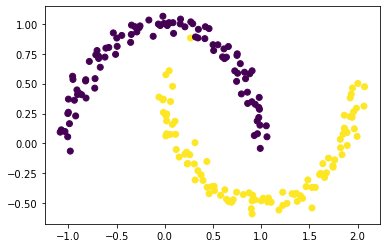

In [52]:
#Create a scatter plot with colored labels based on if z_min is positive or not
plt.scatter(X[:,0], X[:,1], c = (z_min > 0))

It looks like we did a good job!

### An alternative to explicit optimization

This optimization took a long time and is thus impractical for larger datasets. But there is an alternative, which is what the *spectral* in spectral clustering refers to. Instead of explicitly optimizing the equation, we can instead solve the optimization problem using eigenvalues and eigenvectors.

Recall the objective is to minimize with respect to $\mathbf{z}$ 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

subject to $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$.

According to the Rayleigh-Ritz theorem, the $\mathbf{z}$ that minimizes the function must have the smallest eigenvalue of the generalized eigenvalue problem, which is equivalent to the standard eigenvalue problem

$$ \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{z}\;, \quad \mathbf{z}^T\mathbb{1} = 0\;.$$.

Let's define $\mathbf{L} = \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$, where L is known as the *Laplacian* matrix of the similarity matrix $\mathbf{A}$.

As $\mathbb{1}$ is the eigenvector with the smallest eigenvalue of $\mathbf{L}$, we will want to find the second-smallest eigenvalue of $\mathbf{L}$.

First we'll calculate $\mathbf{L}$.

In [53]:
#Find the inverse of D
D_inv = np.linalg.inv(D)

#Calculate L according to the formula
L = D_inv @ (D - A)

Now we'll find the second smallest eigenvalue.

In [54]:
#Get the eigenvalues and eigenvectors
Lam, U = np.linalg.eig(L)

#Get the index for the sorted eigenvalues
index = Lam.argsort()

#Sort the eigenvalues and eigenvectors
Lam, U = Lam[index], U[:,index]

#Save the second eigenvector corresponding to the 2nd smallest eigenvalue
z_eig = U[:,1]

Let's plot the data, using `z_eig` as the labels and see how it looks.

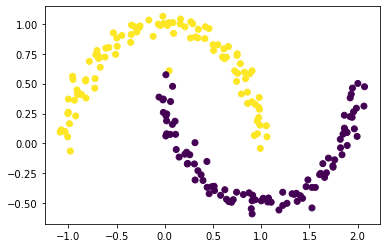

In [55]:
plt.scatter(X[:,0], X[:,1], c = (z_eig > 0))

It looks good!

## Generalizing and applying our solution 

### Creating a function

We just went through all of the steps of spectral clustering. Now we are ready to make a function that will do the process for any inputted data.

In [56]:
"""
This function will perform spectral clustering on the inputted data
to separate it into two clusters

Inputs: X - the data
        epsilong - the parameter that measures similarity

Outputs: the labels predicted by the algorithm
"""
def spectral_clustering(X, epsilon):
    #Find the similarity matrix
    A = sklearn.metrics.pairwise_distances(X) < epsilon
    
    #Construct the Laplacian matrix 
    D = np.diag(A.sum(axis = 1))
    D_inv = np.linalg.inv(D)
    L = D_inv @ (D - A)
    
    #Get second smallest eigenvector
    Lam, U = np.linalg.eig(L)
    index = Lam.argsort()
    Lam, U = Lam[index], U[:,index]
    z_eig = U[:,1]
    
    #Return the labels as ints of 0 and 1
    return (z_eig > 0).astype(int)

We will now demonstrate our function on the data we've been using and see the labels.

In [58]:
spectral_clustering(X, epsilon)

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1])

### Experimenting with the noise

Let's test our our function on some differnt `make_moons` datasets with different parameters for `noise`.

First let's see what happens when we reduce the noise.

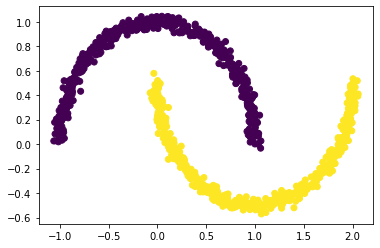

In [60]:
#Make the dataset
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.03, random_state=None)

#Plot it
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X, epsilon))

The data is more clustered into the moons, and the algorithm appears to be exactly correct.

Now let's increase the noise some.

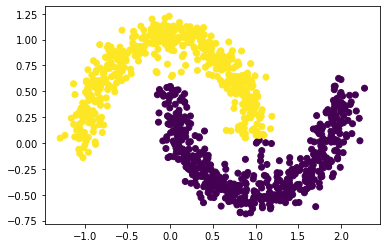

In [61]:
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X, epsilon))

The data is more spread out and there are a couple point on the edge that the algorithm mislabels, but a couple are ambiguous even to the human eye.

Now lets increase the noise even more.

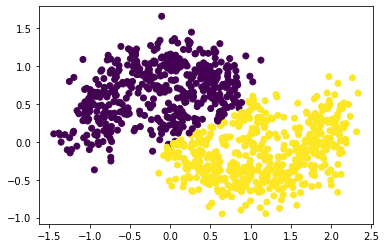

In [62]:
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.20, random_state=None)

plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X, epsilon))

At this point our algorithm does not distinguish the two crescents but they are barely present to the human eye.

### Clustering on a bull's eye

Now we are going to try our spectral clustering function on another kind of data set. This is what the bull's eye looks like.

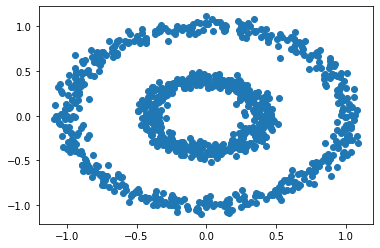

In [63]:
n = 1000
#Create circles for the bull's eye
X, y = datasets.make_circles(n_samples=n, shuffle=True, noise=0.05, random_state=None, factor = 0.4)

#Plot it
plt.scatter(X[:,0], X[:,1])

With some experimentation with the `epsilon`, our function can separate the two rings when `epsilon` is between `0.34` and `0.53`.

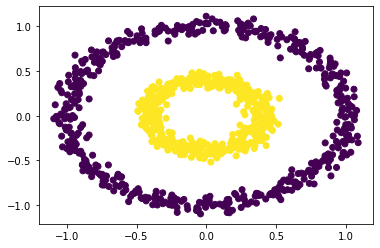

In [64]:
#Make the labels with the given epsilon
labels = spectral_clustering(X, .34)

#Plot it
plt.scatter(X[:,0], X[:,1], c = labels)

When epsilon is below `0.34`, there is no distinction between the circles.

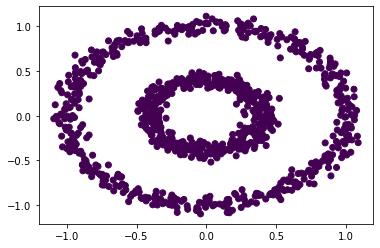

In [66]:
labels = spectral_clustering(X, .32)
plt.scatter(X[:,0], X[:,1], c = labels)

And when `epsilon` is above `0.5`, the circles are split roughtly in half, top to bottom. This division becomes more strictly half as `epsilon` increases.

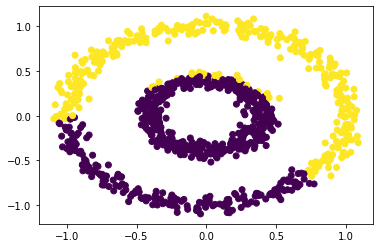

In [68]:
labels = spectral_clustering(X, .55)
plt.scatter(X[:,0], X[:,1], c = labels)